In [35]:
from enum import unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import matplotlib as mpl
import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder,StandardScaler
# from  sklearn.feature_extraction.text import CountVectorizer
# from sklearn import metrics
# from xgboost import XGBRegressor
# from datetime import datetime



import warnings

from fontTools.subset import subset

warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('Customer_Segmentation.csv')
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Finding missing values

In [37]:
counts_missing = df.isnull().sum()
missing_percentage = (counts_missing / len(df)) * 100

#summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': counts_missing,
    'Percentage': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})
print(missing_summary)

                 Column  Missing Values  Percentage
0                    ID               0    0.000000
1            Year_Birth               0    0.000000
2             Education               0    0.000000
3        Marital_Status               0    0.000000
4                Income              24    1.071429
5               Kidhome               0    0.000000
6              Teenhome               0    0.000000
7           Dt_Customer               0    0.000000
8               Recency               0    0.000000
9              MntWines               0    0.000000
10            MntFruits               0    0.000000
11      MntMeatProducts               0    0.000000
12      MntFishProducts               0    0.000000
13     MntSweetProducts               0    0.000000
14         MntGoldProds               0    0.000000
15    NumDealsPurchases               0    0.000000
16      NumWebPurchases               0    0.000000
17  NumCatalogPurchases               0    0.000000
18    NumSto

# Filling missing data
## Income
we have 24 missing values in the Income column, which is significant. We will handle this by using median imputation.

1. Median is robust to outliers, which is important for income data that may have extreme values.
2. It preserves the distribution of the data better than mean imputation.

In [38]:
#we decided to use median impoutation for the missing values in Income column.This is because of the following reasons

df['Income'].fillna(df['Income'].median(), inplace=True)
print(df["Income"].isnull().sum())


0


## Finding duplicates
No duplicates found

In [39]:
df.duplicated().sum()

0

## Date Formatting
Dt_Customer is in the format of 'dd-mm-yyyy', we will convert it to a datetime object for easier analysis.

In [40]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
print("First 20 enrollment dates:")
print(df['Dt_Customer'].head(20))

print('\nNull vales after formatting: ')
print(df[df['Dt_Customer'].isnull()])

First 20 enrollment dates:
0    2012-09-04
1    2014-03-08
2    2013-08-21
3    2014-02-10
4    2014-01-19
5    2013-09-09
6    2012-11-13
7    2013-05-08
8    2013-06-06
9    2014-03-13
10   2013-11-15
11   2012-11-13
12   2013-11-15
13   2013-11-15
14   2012-10-10
15   2012-11-24
16   2012-12-24
17   2012-08-31
18   2013-03-28
19   2012-11-03
Name: Dt_Customer, dtype: datetime64[ns]

Null vales after formatting: 
Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

[0 rows x 29 columns]


## Checking for constant columns
Constant columns are those that have the same value for all rows. These columns do not provide any useful information for analysis or modeling, so they can be safely removed.

In [41]:

constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(constant_columns)


['Z_CostContact', 'Z_Revenue']


## Dropping constant

### found 2
- AcceptedCmp3
- Z_Revenue

We found 2 constant columns: 'AcceptedCmp3' and 'Z_Revenue'. These columns have the same value for all rows, which means they do not provide any useful information for analysis or modeling. Therefore, we will drop them from the dataset.

In [42]:

# Remove constant columns
df = df.drop(columns=constant_columns)

print(f"Removed {len(constant_columns)} constant columns: {constant_columns}")

Removed 2 constant columns: ['Z_CostContact', 'Z_Revenue']


## Finding Outliers
Using the Interquartile Range (IQR) method to identify outliers in numerical columns. The IQR is a measure of statistical dispersion and is used to detect outliers by calculating the range between the first quartile (Q1) and the third quartile (Q3).


In [43]:
#identifying outliers using IQR method
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude ID and boolean columns
bool_cols = [col for col in df.columns if np.all(np.isin(df[col].unique(), [0, 1]))]
numerical_cols = [col for col in numerical_cols if col not in bool_cols and col != 'ID']
# list of Outlier
def outlier_summary(dataframe):

    outlier_info = []
    total_outliers = 0

    for col in numerical_cols:
        # Calculate IQR
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        # Find outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_percentage = (outlier_count / len(dataframe)) * 100
            outlier_info.append((col, outlier_count, outlier_percentage))
            total_outliers += outlier_count

    print(f"Columns with outliers: {len(outlier_info)}")
    print(f"Total outliers: {total_outliers}")

    if outlier_info:
        print("Columns with outliers:")
        print()
        # Sort by outlier count (descending)
        #outlier_info.sort(key=lambda x: x[1], reverse=True)

        for col, count, percentage in outlier_info:
            print(f"{col}: {count} outliers ({percentage:.1f}%)")
    else:
        print("No outliers detected in any column!")

# Run the outlier summary
outlier_summary(df)


Columns with outliers: 12
Total outliers: 1247
Columns with outliers:

Year_Birth: 3 outliers (0.1%)
Income: 8 outliers (0.4%)
MntWines: 35 outliers (1.6%)
MntFruits: 227 outliers (10.1%)
MntMeatProducts: 175 outliers (7.8%)
MntFishProducts: 223 outliers (10.0%)
MntSweetProducts: 248 outliers (11.1%)
MntGoldProds: 207 outliers (9.2%)
NumDealsPurchases: 86 outliers (3.8%)
NumWebPurchases: 4 outliers (0.2%)
NumCatalogPurchases: 23 outliers (1.0%)
NumWebVisitsMonth: 8 outliers (0.4%)


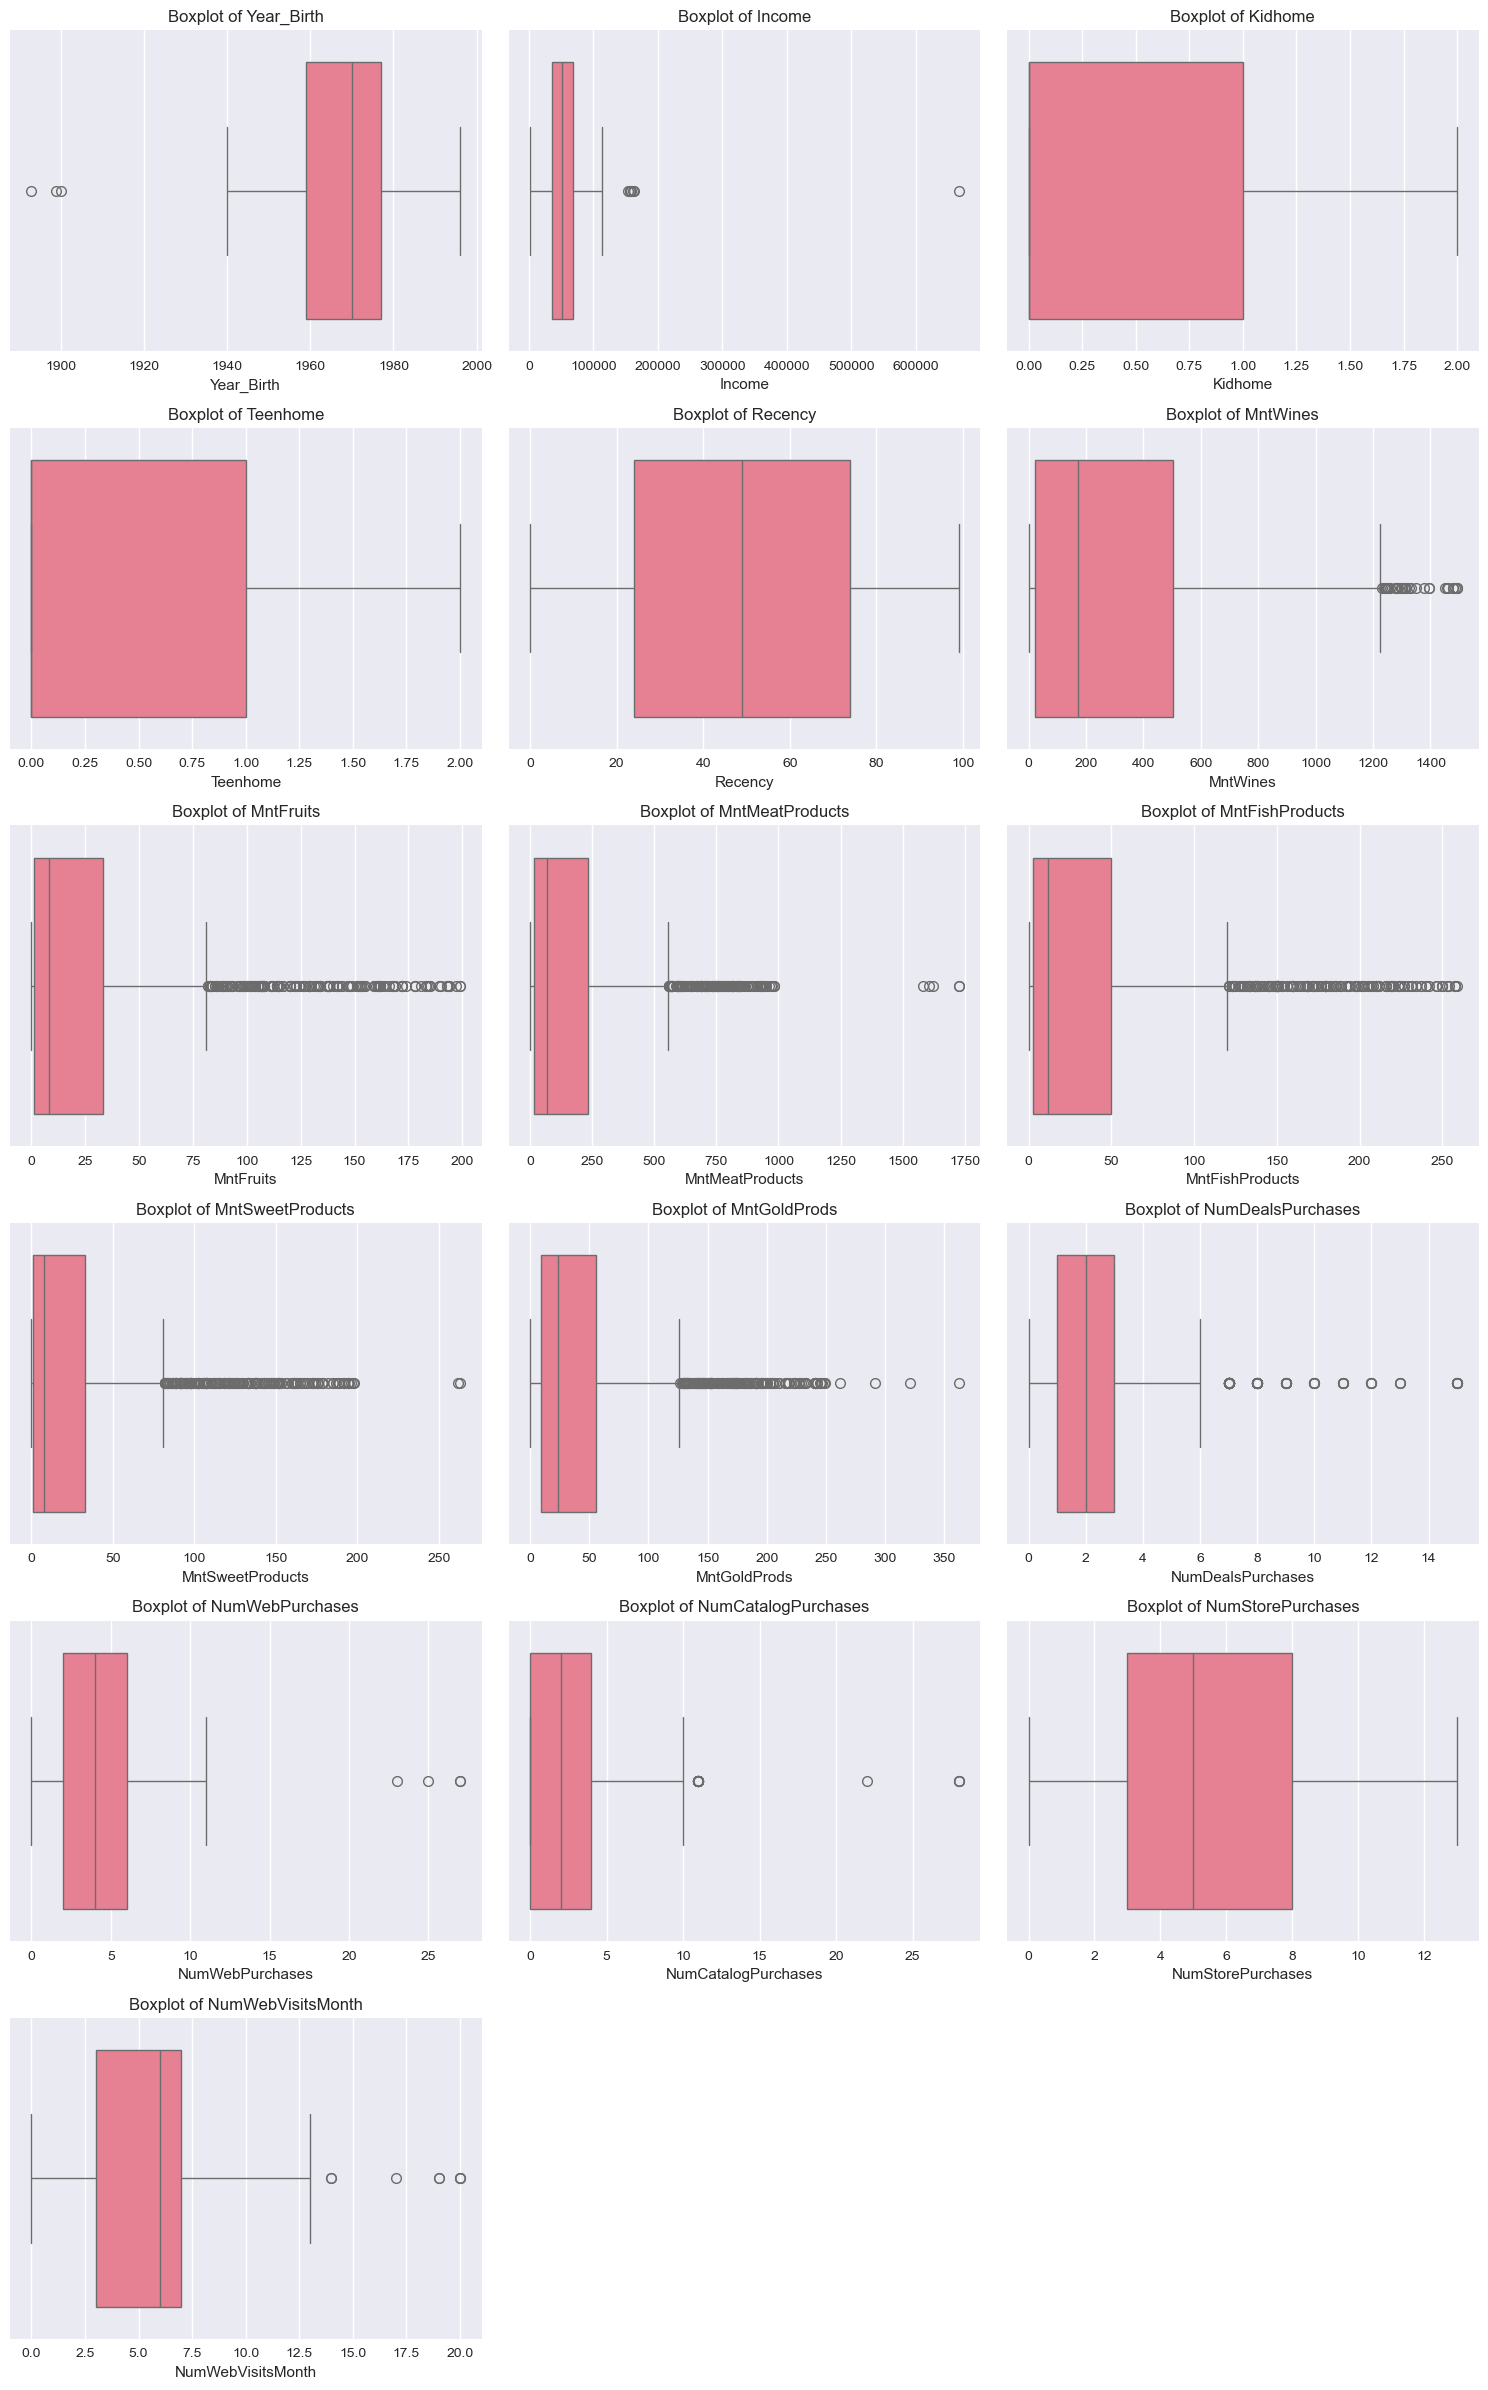

In [44]:
#visualize the outliers using boxplots
def plot_outliers(dataframe):
    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=dataframe[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()


# Run the outlier visualization
plot_outliers(df)


## handling the outliers
# We will use the capping method to handle outliers. This involves replacing outliers with the nearest non-outlier value, which is determined by the IQR method.


In [45]:
# Capping method to handle outliers
def cap_outliers(dataframe):

    df_capped = dataframe.copy()

    for col in numerical_cols:
        # Calculate IQR
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before capping
        outliers_before = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])

        # Apply capping
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)

        # Count outliers after capping
        outliers_after = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])

        if outliers_before > 0:
            print(f"{col}: {outliers_before} outliers capped")

    print(f"\nOutlier capping completed!")
    return df_capped #return the capped DataFrame while preserving the original DataFrame

# Apply capping to the dataset
df_capped = cap_outliers(df)





Year_Birth: 3 outliers capped
Income: 8 outliers capped
MntWines: 35 outliers capped
MntFruits: 227 outliers capped
MntMeatProducts: 175 outliers capped
MntFishProducts: 223 outliers capped
MntSweetProducts: 248 outliers capped
MntGoldProds: 207 outliers capped
NumDealsPurchases: 86 outliers capped
NumWebPurchases: 4 outliers capped
NumCatalogPurchases: 23 outliers capped
NumWebVisitsMonth: 8 outliers capped

Outlier capping completed!


## Visualizatin after capping
# Visualize the capped data using boxplots
We will create boxplots for each numerical column to visualize the effect of capping on outliers. The boxplots will show the distribution of the data and highlight any remaining outliers after capping.

Boxplots of capped data only:


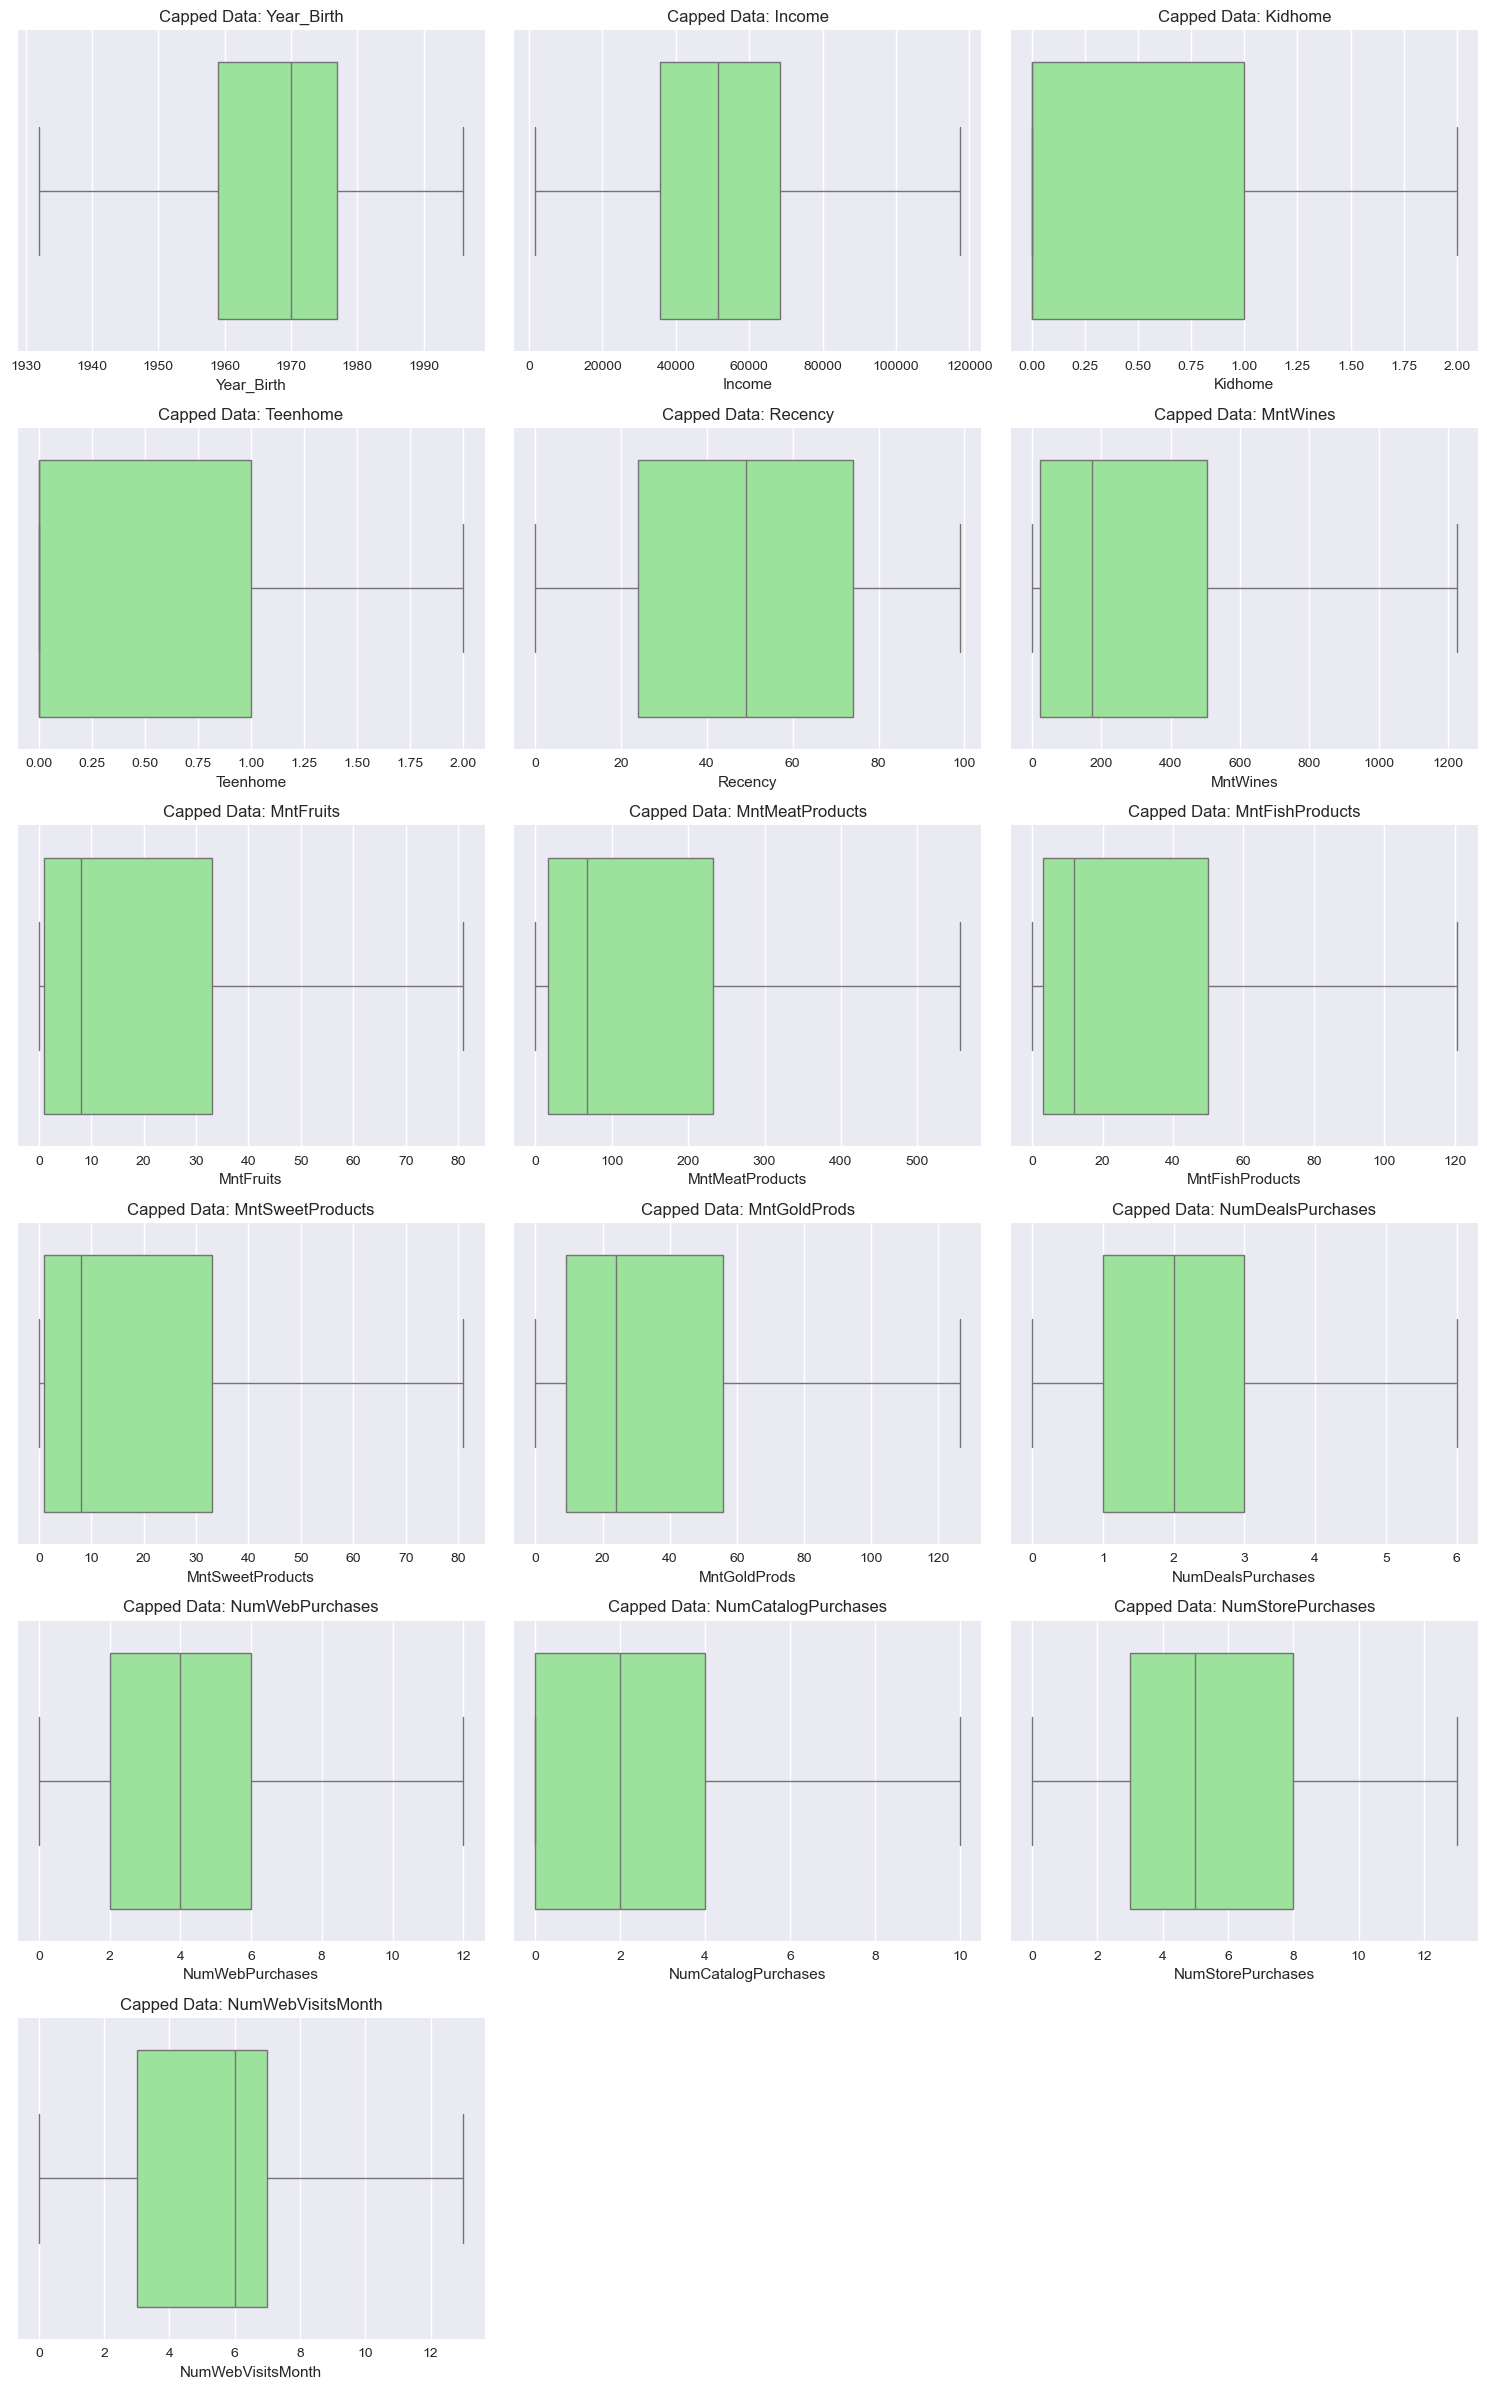

Existing cleaned_customer_segmentation.csv found, removing it...
File removed successfully.
New cleaned_customer_segmentation.csv saved successfully (216.94 KB)
Loaded cleaned dataset with shape: (2240, 27)


In [46]:


# Also created a simple boxplot of just the capped data
def plot_capped_data_only(capped_df):

    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')

    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=capped_df[col], color='lightgreen')
        plt.title(f'Capped Data: {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

print("Boxplots of capped data only:")
plot_capped_data_only(df_capped)

# Check if the cleaned customer CSV exists
if os.path.exists('cleaned_customer_segmentation.csv'):
    print(f"Existing cleaned_customer_segmentation.csv found, removing it...")
    os.remove('cleaned_customer_segmentation.csv')
    print("File removed successfully.")

# Save the new cleaned dataset
df_capped.to_csv('cleaned_customer_segmentation.csv', index=False)
print(f"New cleaned_customer_segmentation.csv saved successfully ({os.path.getsize('cleaned_customer_segmentation.csv')/1024:.2f} KB)")

# Verify the file was saved correctly
if os.path.exists('cleaned_customer_segmentation.csv'):
    # Load the cleaned dataset to confirm it was saved properly
    df_cleaned = pd.read_csv('cleaned_customer_segmentation.csv')
    print(f"Loaded cleaned dataset with shape: {df_cleaned.shape}")

## Feature Egineering
Feature engineering is the process of using domain knowledge to extract features from raw data that make machine learning algorithms work. In this section, we will create new features based on the existing data in the dataset.

In [47]:
from sklearn.preprocessing import LabelEncoder
# Load data
df = pd.read_csv('cleaned_customer_segmentation.csv')


## Text encoding
### Education
- we chose ordinal encoding to put into perspective the increasing level of education
1. first we will find the unique eduaction levels

In [48]:


unique_eduaction_levels= df['Education'].unique()

print(unique_eduaction_levels)

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


## next steps
2. supply ordinal encoder with oredered categories

`['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
`

3. fit the education column

In [49]:
from sklearn.preprocessing import OrdinalEncoder

ordered_education_categories = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
ordinal_encoder = OrdinalEncoder(categories=[ordered_education_categories])

education_encoded = ordinal_encoder.fit_transform(df[['Education']])

df['Education'] = education_encoded

In [50]:

print('Unique Marital Status:')
print(df['Marital_Status'].unique())
print('\nMarital Status value counts:')
print(df['Marital_Status'].value_counts())

Unique Marital Status:
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

Marital Status value counts:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


## Marital status evaluation

### Unique Marital Status:
`['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
`
### Marital Status value counts:
`Marital_Status,
Married     864,
Together    580,
Single      480,
Divorced    232,
Widow        77,
Alone         3,
Absurd        2`

## Deduction
### Wrong data
- Yolo alone and absurd are wrong data entries.
- Alone is the same as single and its values can be replaced with single
- Absurd and yolo will be replaced with the mode



In [51]:
# replace Alone with Single
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
print('\nMode: ',df['Marital_Status'].mode()[0])
# Absurd and yolo  replaced with the mode
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO','Absurd'], df['Marital_Status'].mode()[0])

#now check for the current state
print('Unique Marital Status:')
print(df['Marital_Status'].unique())
print('\nMarital Status value counts:')
print(df['Marital_Status'].value_counts())



Mode:  Married
Unique Marital Status:
['Single' 'Together' 'Married' 'Divorced' 'Widow']

Marital Status value counts:
Marital_Status
Married     868
Together    580
Single      483
Divorced    232
Widow        77
Name: count, dtype: int64


### marital status encoding
We went with **one hot encoding**,
this is because ~~nominal encoding~~ would create a non existent _hierachy_

In [52]:
# One-hot encode marital status
marital_dummies = pd.get_dummies(df['Marital_Status'], prefix='Marital')
df = pd.concat([df.drop('Marital_Status', axis=1), marital_dummies], axis=1)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   float64
 3   Income               2240 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   float64
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   float64
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In [53]:

# Feature engineering with corrected date parsing
try:

    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed', dayfirst=True)
except ValueError:

    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')

# Ensure Education is properly encoded as numbers
print("Education column before encoding:")
print(f"Data type: {df['Education'].dtype}")
print(f"Unique values: {df['Education'].unique()}")

# If Education is still text, encode it properly
if df['Education'].dtype == 'object':
    education_mapping = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
    df['Education'] = df['Education'].map(education_mapping)
    print("Education encoded using mapping")
else:
    print("Education already encoded")

print("Education column after encoding:")
print(f"Data type: {df['Education'].dtype}")
print(f"Unique values: {sorted(df['Education'].unique())}")

df['Age'] = 2025- df['Year_Birth']
df['Total_Dependents'] = df['Kidhome'] + df['Teenhome']
df['Is_Parent'] = (df['Total_Dependents'] > 0).astype(int)
df['Total_Spending'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df['Average_Spent'] = df['Total_Spending']/df['Total_Purchases'].replace(0,1)
df['Tenure_Days'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days
df['Total_Accepted_Cmp']=df[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=1)
df['Web_Ratio'] = df['NumWebPurchases'] / df['Total_Purchases']
df['Store_Ratio'] = df['NumStorePurchases'] / df['Total_Purchases']
df['Catalog_Ratio'] = df['NumCatalogPurchases'] / df['Total_Purchases']
df['Deals_Ratio'] = df['NumDealsPurchases'] / df['Total_Purchases']
df['Ever_Accepted_Campaign'] = (df['Total_Accepted_Cmp'] > 0).astype(int)

# Verify date conversion
print("\nDate conversion samples:")
print(df[['Dt_Customer', 'Tenure_Days']].head())

# Drop unnecessary columns
# df = df.drop(['ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue','Complain','Response','Kidhome', 'Teenhome','AcceptedCmp1','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds'], axis=1, errors='ignore')

# Check if the featured customer CSV exists
if os.path.exists('featured_customer_segmentation.csv'):
    print(f"Existing featured_customer_segmentation.csv found, removing it...")
    os.remove('featured_customer_segmentation.csv')
    print("File removed successfully.")

# Save the new featured dataset
df.to_csv('featured_customer_segmentation.csv', index=False)
print(f"New featured_customer_segmentation.csv saved successfully ({os.path.getsize('featured_customer_segmentation.csv')/1024:.2f} KB)")



Education column before encoding:
Data type: float64
Unique values: [2. 4. 3. 0. 1.]
Education already encoded
Education column after encoding:
Data type: float64
Unique values: [0.0, 1.0, 2.0, 3.0, 4.0]

Date conversion samples:
  Dt_Customer  Tenure_Days
0  2012-09-04         4698
1  2014-03-08         4148
2  2013-08-21         4347
3  2014-02-10         4174
4  2014-01-19         4196
Existing featured_customer_segmentation.csv found, removing it...
File removed successfully.
New featured_customer_segmentation.csv saved successfully (448.91 KB)


In [62]:
# Feature Engineering Evaluation and Analysis
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('featured_customer_segmentation.csv')

print("Dataset Analysis")
print("-" * 40)
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

# Data preparation function
def prepare_clustering_data(data, feature_list):
    # Check which features actually exist
    valid_features = [f for f in feature_list if f in data.columns]
    missing_features = [f for f in feature_list if f not in data.columns]
    
    if missing_features:
        print(f"Missing: {missing_features}")
    
    X = data[valid_features].copy()
    
    # Handle different data types
    for col in X.columns:
        if X[col].dtype == 'object':
            if col == 'Education':
                # Map education levels
                edu_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
                X[col] = X[col].map(edu_map)
            else:
                # Label encode other categorical variables
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
        
        # Fill missing values with mean
        if X[col].dtype in ['int64', 'float64'] and X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Convert everything to numeric
    for col in X.columns:
        if X[col].dtype not in ['int64', 'float64']:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(X[col].mean())
    
    return X

# Define feature sets
business_metrics = [
    'Age', 'Total_Dependents', 'Is_Parent', 
    'Total_Spending', 'Total_Purchases', 'Average_Spent', 
    'Tenure_Days', 'Total_Accepted_Cmp', 
    'Ever_Accepted_Campaign', 'Income'
]

# Check available features
available_features = [f for f in business_metrics if f in df.columns]
print(f"\nUsing features: {available_features}")

# Clustering evaluation
def run_clustering_analysis(data, features, analysis_name):
    print(f"\n{analysis_name}")
    print("-" * 50)
    
    X = prepare_clustering_data(data, features)
    
    if X.empty:
        print("No valid features found")
        return None
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    results = []
    
    # Test different cluster numbers
    for k in range(2, 8):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        
        sil_score = silhouette_score(X_scaled, labels)
        inertia = kmeans.inertia_
        
        results.append({
            'k': k,
            'silhouette': sil_score,
            'inertia': inertia
        })
        
        print(f"K={k}: Silhouette={sil_score:.4f}, Inertia={inertia:.0f}")
    
    # Find best result
    best_result = max(results, key=lambda x: x['silhouette'])
    print(f"\nBest: K={best_result['k']}, Score={best_result['silhouette']:.4f}")
    
    return {
        'results': results,
        'best_k': best_result['k'],
        'best_score': best_result['silhouette'],
        'feature_count': len(X.columns)
    }

# Run the analysis
analysis_results = run_clustering_analysis(df, available_features, "Business Feature Analysis")

if analysis_results:
    print(f"\nSummary")
    print("-" * 30)
    print(f"Best cluster count: {analysis_results['best_k']}")
    print(f"Silhouette score: {analysis_results['best_score']:.4f}")
    print(f"Features used: {analysis_results['feature_count']}")
    print(f"Interpretable: {'Yes' if analysis_results['feature_count'] <= 10 else 'No'}")

Dataset Analysis
----------------------------------------
Shape: (2240, 44)
Columns: 44

Using features: ['Age', 'Total_Dependents', 'Is_Parent', 'Total_Spending', 'Total_Purchases', 'Average_Spent', 'Tenure_Days', 'Total_Accepted_Cmp', 'Ever_Accepted_Campaign', 'Income']

Business Feature Analysis
--------------------------------------------------
K=2: Silhouette=0.3212, Inertia=15006
K=3: Silhouette=0.2933, Inertia=12312
K=4: Silhouette=0.2496, Inertia=10871
K=5: Silhouette=0.2733, Inertia=9794
K=6: Silhouette=0.2898, Inertia=8868
K=7: Silhouette=0.2481, Inertia=8159

Best: K=2, Score=0.3212

Summary
------------------------------
Best cluster count: 2
Silhouette score: 0.3212
Features used: 10
Interpretable: Yes



Data Visualization
----------------------------------------
Available columns:
 1. ID
 2. Year_Birth
 3. Education
 4. Income
 5. Kidhome
 6. Teenhome
 7. Dt_Customer
 8. Recency
 9. MntWines
10. MntFruits
11. MntMeatProducts
12. MntFishProducts
13. MntSweetProducts
14. MntGoldProds
15. NumDealsPurchases
16. NumWebPurchases
17. NumCatalogPurchases
18. NumStorePurchases
19. NumWebVisitsMonth
20. AcceptedCmp3
21. AcceptedCmp4
22. AcceptedCmp5
23. AcceptedCmp1
24. AcceptedCmp2
25. Complain
26. Response
27. Marital_Divorced
28. Marital_Married
29. Marital_Single
30. Marital_Together
31. Marital_Widow
32. Age
33. Total_Dependents
34. Is_Parent
35. Total_Spending
36. Total_Purchases
37. Average_Spent
38. Tenure_Days
39. Total_Accepted_Cmp
40. Web_Ratio
41. Store_Ratio
42. Catalog_Ratio
43. Deals_Ratio
44. Ever_Accepted_Campaign

Visualizing: 10 features


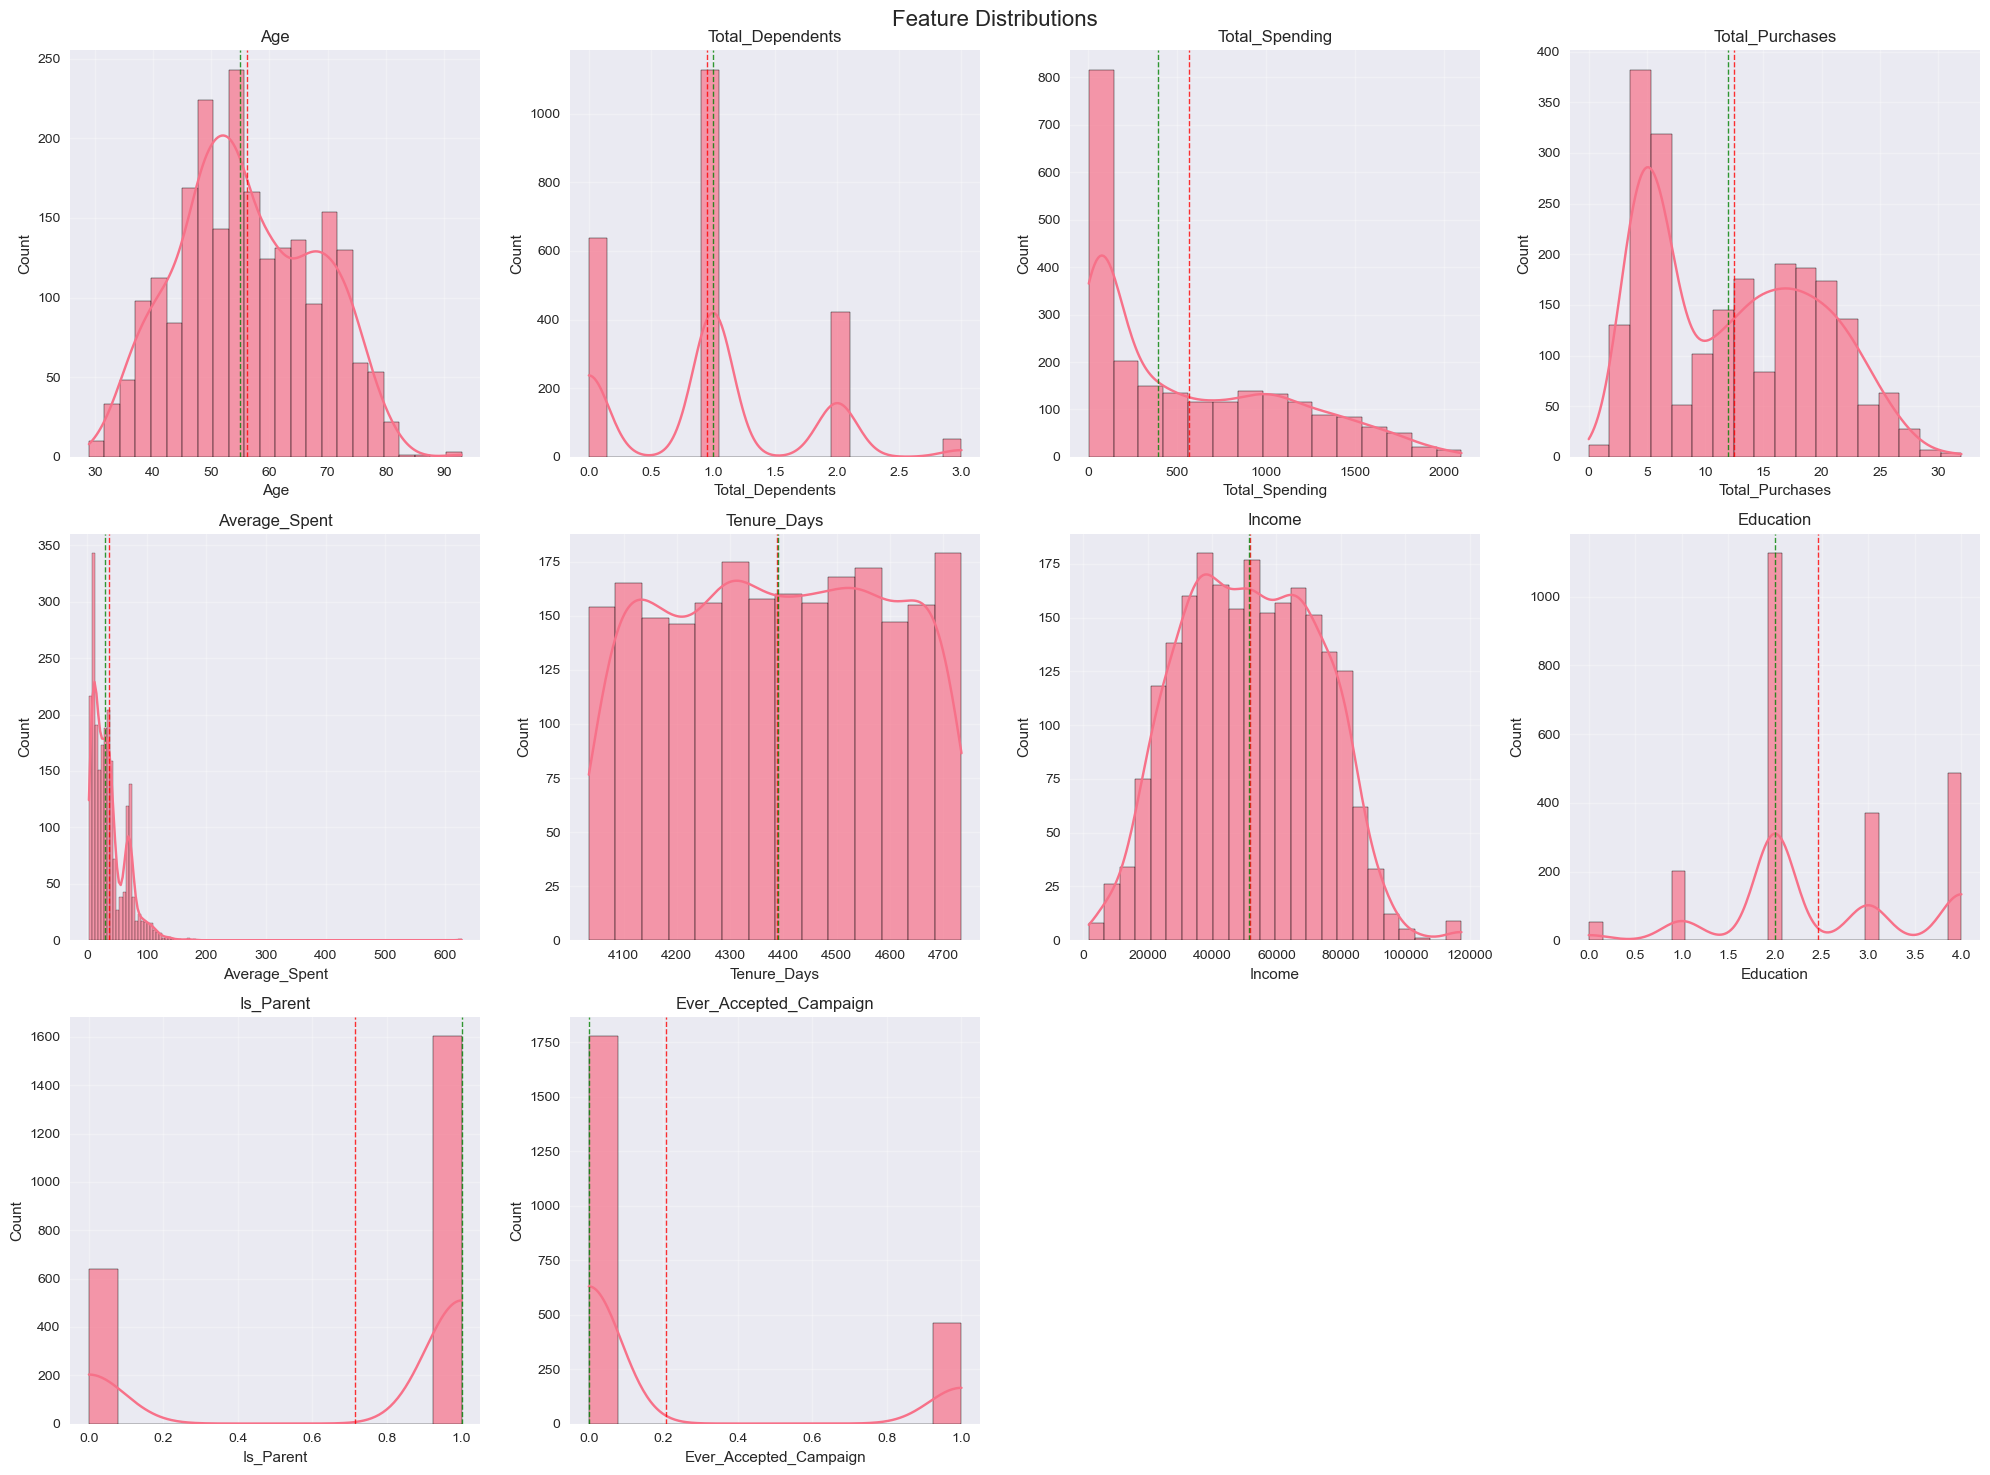

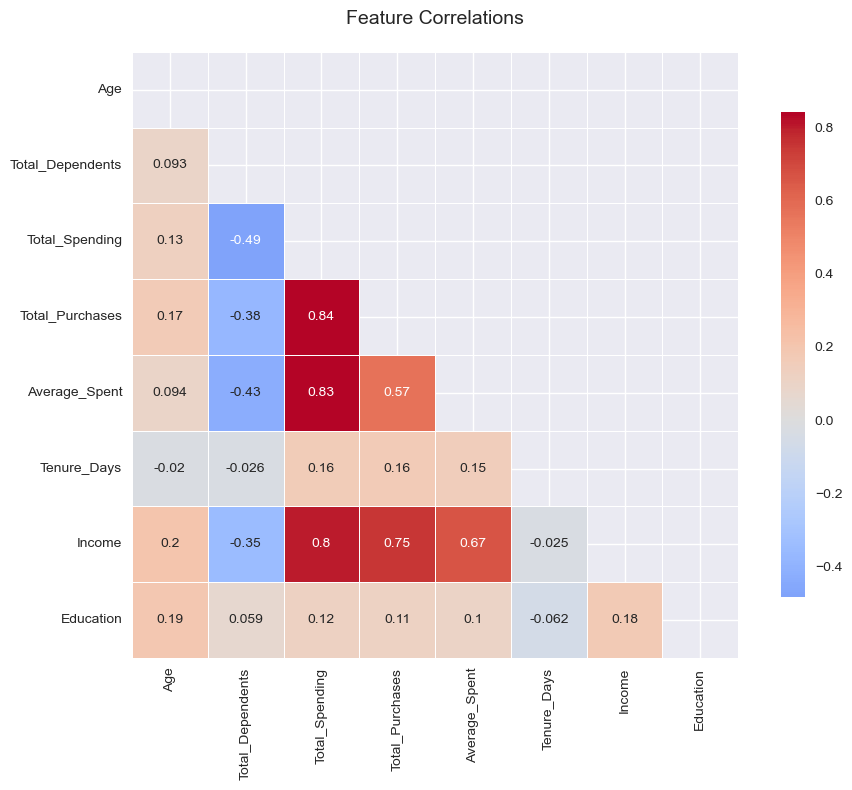


Dataset Summary
Total customers: 2,240
Age range: 29 - 93 years
Average dependents: 1.0
Parents: 1,602 (71.5%)
Average spending: $568
Average tenure: 4389 days
Campaign responders: 463 (20.7%)

Channel Usage:
Web_Ratio: 0.330
Store_Ratio: 0.505
Catalog_Ratio: 0.165
Deals_Ratio: inf

Key Insights:
- Created business-focused metrics from raw transaction data
- Simplified feature set for better interpretability
- Ready for customer segmentation analysis
- Features capture customer lifecycle and behavior patterns


In [63]:
# Data Visualization and Summary
print("\nData Visualization")
print("-" * 40)

# Show all columns
print("Available columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# Select features for visualization
viz_features = []
target_features = ['Age', 'Total_Dependents', 'Total_Spending', 'Total_Purchases',
                   'Average_Spent', 'Tenure_Days', 'Income', 'Education', 
                   'Is_Parent', 'Ever_Accepted_Campaign']

for feature in target_features:
    if feature in df.columns:
        viz_features.append(feature)

print(f"\nVisualizing: {len(viz_features)} features")

# Create distribution plots
if len(viz_features) > 0:
    n_plots = min(12, len(viz_features))
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Feature Distributions', fontsize=16, y=0.98)
    
    for idx, feature in enumerate(viz_features[:n_plots]):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        try:
            sns.histplot(data=df, x=feature, kde=True, ax=ax, alpha=0.7)
            ax.set_title(f'{feature}')
            ax.grid(True, alpha=0.3)
            
            # Add mean and median lines
            mean_val = df[feature].mean()
            median_val = df[feature].median()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, linewidth=1)
            ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, linewidth=1)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {feature}', ha='center', va='center', transform=ax.transAxes)
    
    # Remove empty subplots
    for idx in range(n_plots, 12):
        row = idx // 4
        col = idx % 4
        if row < 3 and col < 4:
            axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()

# Correlation analysis
corr_features = ['Age', 'Total_Dependents', 'Total_Spending', 'Total_Purchases', 
                'Average_Spent', 'Tenure_Days', 'Income', 'Education']

available_corr = [f for f in corr_features if f in df.columns]

if len(available_corr) > 1:
    plt.figure(figsize=(10, 8))
    
    corr_matrix = df[available_corr].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Feature Correlations', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Dataset summary
print("\nDataset Summary")
print("=" * 50)
print(f"Total customers: {len(df):,}")

# Basic statistics
if 'Age' in df.columns:
    print(f"Age range: {df['Age'].min():.0f} - {df['Age'].max():.0f} years")
if 'Total_Dependents' in df.columns:
    print(f"Average dependents: {df['Total_Dependents'].mean():.1f}")
if 'Is_Parent' in df.columns:
    parents = df['Is_Parent'].sum()
    print(f"Parents: {parents:,} ({parents/len(df)*100:.1f}%)")
if 'Total_Spending' in df.columns:
    print(f"Average spending: ${df['Total_Spending'].mean():.0f}")
if 'Tenure_Days' in df.columns:
    print(f"Average tenure: {df['Tenure_Days'].mean():.0f} days")
if 'Ever_Accepted_Campaign' in df.columns:
    responders = df['Ever_Accepted_Campaign'].sum()
    print(f"Campaign responders: {responders:,} ({responders/len(df)*100:.1f}%)")

# Channel analysis
channel_cols = ['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio']
available_channels = [c for c in channel_cols if c in df.columns]

if available_channels:
    print(f"\nChannel Usage:")
    for channel in available_channels:
        print(f"{channel}: {df[channel].mean():.3f}")

print(f"\nKey Insights:")
print(f"- Created business-focused metrics from raw transaction data")
print(f"- Simplified feature set for better interpretability")
print(f"- Ready for customer segmentation analysis")
print(f"- Features capture customer lifecycle and behavior patterns")

In [59]:
# Fixed Comprehensive Feature Engineering Evaluation

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
df_original = pd.read_csv('cleaned_customer_segmentation.csv')
df_featured = pd.read_csv('featured_customer_segmentation.csv')

print("=== COMPREHENSIVE FEATURE ENGINEERING EVALUATION ===\n")
print(f"Original dataset columns: {list(df_original.columns)}")
print(f"Featured dataset columns: {list(df_featured.columns)}")

# Function to safely prepare data for clustering
def prepare_data_safely(data, features):
    """Prepare data by handling text columns and missing values"""
    available_features = [f for f in features if f in data.columns]
    missing_features = [f for f in features if f not in data.columns]
    
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
    
    X = data[available_features].copy()
    print(f"Available features: {available_features}")
    
    # Handle each column based on its data type
    for col in X.columns:
        if X[col].dtype == 'object':
            # Handle text columns
            if col == 'Education':
                # Use specific mapping for education
                education_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
                X[col] = X[col].map(education_map)
                print(f"Mapped Education: {X[col].unique()}")
            else:
                # Use label encoding for other text columns
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                print(f"Label encoded {col}: {X[col].unique()}")
        
        # Handle missing values for numeric columns
        if X[col].dtype in ['int64', 'float64']:
            missing_count = X[col].isnull().sum()
            if missing_count > 0:
                X[col] = X[col].fillna(X[col].mean())
                print(f"Filled {missing_count} missing values in {col}")
    
    # Final verification - ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype not in ['int64', 'float64']:
            print(f"Warning: {col} is still not numeric: {X[col].dtype}")
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(X[col].mean())
    
    print(f"Final data shape: {X.shape}")
    return X

# Define feature sets with CORRECT column names
original_features = [
    'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumDealsPurchases', 'NumWebVisitsMonth',
    'Education', 'Recency', 'Kidhome', 'Teenhome'
]

business_features = [
    'Age', 'Total_Dependents', 'Is_Parent', 
    'Total_Spending', 'Total_Purchases', 'Average_Spent', 
    'Tenure_Days', 'Total_Accepted_Cmp', 
    'Ever_Accepted_Campaign', 'Income'
]

# Fixed channel features with correct column names
channel_features = [
    'Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio',  # Fixed names
    'Total_Purchases', 'Average_Spent', 'Income', 'Age'
]

# Function to evaluate clustering with error handling
def evaluate_comprehensive(data, features, name, k_range=range(2, 8)):
    print(f"\n{'='*50}")
    print(f"{name} Analysis:")
    print(f"{'='*50}")
    
    try:
        X = prepare_data_safely(data, features)
        
        if X.empty or len(X.columns) == 0:
            print(f"Error: No valid features for {name}")
            return create_empty_results()
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        silhouette_scores = []
        inertias = []
        
        print(f"\nClustering results for {name}:")
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            
            sil_score = silhouette_score(X_scaled, cluster_labels)
            inertia = kmeans.inertia_
            
            silhouette_scores.append(sil_score)
            inertias.append(inertia)
            
            print(f"K={k}: Silhouette={sil_score:.4f}, Inertia={inertia:.0f}")
        
        # Find best configuration
        best_sil_idx = np.argmax(silhouette_scores)
        best_k = list(k_range)[best_sil_idx]
        best_score = silhouette_scores[best_sil_idx]
        
        print(f"\n🏆 Best result: K={best_k}, Silhouette={best_score:.4f}")
        
        return {
            'silhouette_scores': silhouette_scores,
            'inertias': inertias,
            'best_k': best_k,
            'best_score': best_score,
            'feature_count': len(X.columns),
            'interpretability': len(X.columns) <= 10,
            'success': True,
            'features_used': list(X.columns)
        }
        
    except Exception as e:
        print(f" Error in {name}: {str(e)}")
        return create_empty_results()

def create_empty_results():
    return {
        'silhouette_scores': [],
        'inertias': [],
        'best_k': 0,
        'best_score': 0,
        'feature_count': 0,
        'interpretability': False,
        'success': False,
        'features_used': []
    }

# Evaluate all approaches
print(" EVALUATING DIFFERENT FEATURE APPROACHES")
original_results = evaluate_comprehensive(df_original, original_features, "ORIGINAL FEATURES")
business_results = evaluate_comprehensive(df_featured, business_features, "BUSINESS-FOCUSED FEATURES")
channel_results = evaluate_comprehensive(df_featured, channel_features, "CHANNEL-FOCUSED FEATURES")

=== COMPREHENSIVE FEATURE ENGINEERING EVALUATION ===

Original dataset columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
Featured dataset columns: ['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together

=== COMPREHENSIVE FEATURE ENGINEERING EVALUATION ===

 EVALUATING DIFFERENT FEATURE APPROACHES

ORIGINAL FEATURES Analysis:
Available features: ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Education', 'Recency', 'Kidhome', 'Teenhome']
Processing Income: float64
Processing MntWines: int64
Processing MntFruits: int64
Processing MntMeatProducts: int64
Processing MntFishProducts: float64
Processing MntSweetProducts: int64
Processing MntGoldProds: float64
Processing NumWebPurchases: int64
Processing NumCatalogPurchases: int64
Processing NumStorePurchases: int64
Processing NumDealsPurchases: int64
Processing NumWebVisitsMonth: int64
Processing Education: object
Mapped Education: [2 4 3 0 1]
Processing Recency: int64
Processing Kidhome: int64
Processing Teenhome: int64
Final data shape: (2240, 16)
Final data types:
Income   

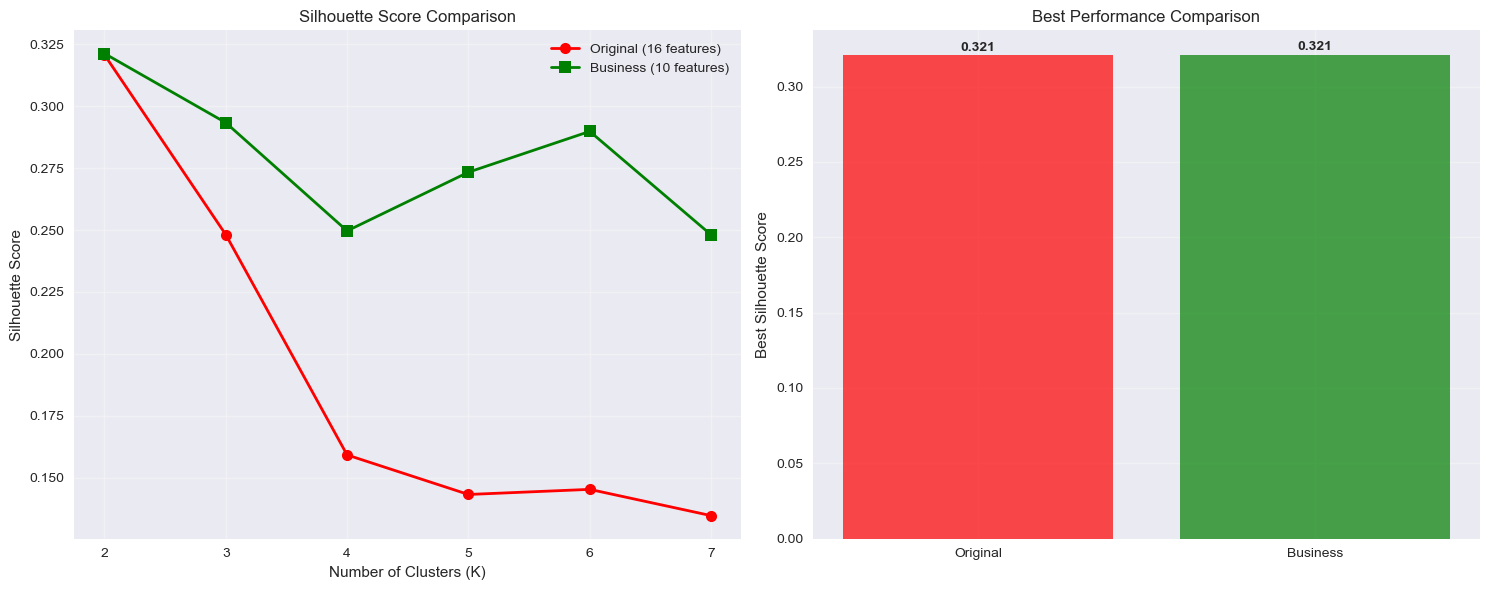


BUSINESS IMPACT OF FEATURE ENGINEERING:
 Actionable Insights: Simplified features enable clear business actions
 Better Targeting: Age, family status, and spending patterns for marketing
 Channel Optimization: Purchase ratios guide channel investment
 Revenue Impact: Customer lifetime value insights from tenure and spending
 Campaign Efficiency: Campaign response patterns for better ROI
 Operational Efficiency: Fewer features = faster analysis and deployment

 KEY FEATURE ENGINEERING WINS:
 Created interpretable business metrics from raw data
 Enabled customer lifecycle analysis (Age, Tenure)
 Introduced family-based segmentation (Total_Dependents, Is_Parent)
 Built channel preference indicators for omnichannel strategy
 Consolidated spending behavior into actionable metrics
 Resolved data encoding and quality issues


In [55]:
# Comprehensive Feature Engineering Evaluation with Better Error Handling

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
df_original = pd.read_csv('cleaned_customer_segmentation.csv')
df_featured = pd.read_csv('featured_customer_segmentation.csv')

print("=== COMPREHENSIVE FEATURE ENGINEERING EVALUATION ===\n")

# Function to safely prepare data for clustering
def prepare_data_safely(data, features):
    """Prepare data by handling text columns and missing values"""
    available_features = [f for f in features if f in data.columns]
    X = data[available_features].copy()
    
    print(f"Available features: {available_features}")
    
    # Handle each column based on its data type
    for col in X.columns:
        print(f"Processing {col}: {X[col].dtype}")
        
        if X[col].dtype == 'object':
            # Handle text columns
            if col == 'Education':
                # Use specific mapping for education
                education_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
                X[col] = X[col].map(education_map)
                print(f"Mapped Education: {X[col].unique()}")
            else:
                # Use label encoding for other text columns
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                print(f"Label encoded {col}: {X[col].unique()}")
        
        # Handle missing values for numeric columns
        if X[col].dtype in ['int64', 'float64']:
            missing_count = X[col].isnull().sum()
            if missing_count > 0:
                X[col] = X[col].fillna(X[col].mean())
                print(f"Filled {missing_count} missing values in {col}")
    
    # Final verification - ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype not in ['int64', 'float64']:
            print(f"Warning: {col} is still not numeric: {X[col].dtype}")
            X[col] = pd.to_numeric(X[col], errors='coerce')
            X[col] = X[col].fillna(X[col].mean())
    
    print(f"Final data shape: {X.shape}")
    print(f"Final data types:\n{X.dtypes}")
    
    return X

# Define feature sets
original_features = [
    'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumDealsPurchases', 'NumWebVisitsMonth',
    'Education', 'Recency', 'Kidhome', 'Teenhome'
]

business_features = [
    'Age', 'Total_Dependents', 'Is_Parent', 
    'Total_Spending', 'Total_Purchases', 'Average_Spent', 
    'Tenure_Days', 'Total_Accepted_Cmp', 
    'Ever_Accepted_Campaign', 'Income'
]

channel_features = [
    'Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio',
    'Total_Purchases', 'Average_Spent', 'Income', 'Age'
]

# Function to evaluate clustering with error handling
def evaluate_comprehensive(data, features, name, k_range=range(2, 8)):
    print(f"\n{'='*50}")
    print(f"{name} Analysis:")
    print(f"{'='*50}")
    
    try:
        X = prepare_data_safely(data, features)
        
        if X.empty or len(X.columns) == 0:
            print(f"Error: No valid features for {name}")
            return create_empty_results()
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        silhouette_scores = []
        inertias = []
        
        print(f"\nClustering results for {name}:")
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            
            sil_score = silhouette_score(X_scaled, cluster_labels)
            inertia = kmeans.inertia_
            
            silhouette_scores.append(sil_score)
            inertias.append(inertia)
            
            print(f"K={k}: Silhouette={sil_score:.4f}, Inertia={inertia:.0f}")
        
        # Find best configuration
        best_sil_idx = np.argmax(silhouette_scores)
        best_k = list(k_range)[best_sil_idx]
        best_score = silhouette_scores[best_sil_idx]
        
        print(f"\n Best result: K={best_k}, Silhouette={best_score:.4f}")
        
        return {
            'silhouette_scores': silhouette_scores,
            'inertias': inertias,
            'best_k': best_k,
            'best_score': best_score,
            'feature_count': len(X.columns),
            'interpretability': len(X.columns) <= 10,
            'success': True
        }
        
    except Exception as e:
        print(f" Error in {name}: {str(e)}")
        return create_empty_results()

def create_empty_results():
    return {
        'silhouette_scores': [],
        'inertias': [],
        'best_k': 0,
        'best_score': 0,
        'feature_count': 0,
        'interpretability': False,
        'success': False
    }

# Evaluate all approaches
print(" EVALUATING DIFFERENT FEATURE APPROACHES")
original_results = evaluate_comprehensive(df_original, original_features, "ORIGINAL FEATURES")
business_results = evaluate_comprehensive(df_featured, business_features, "BUSINESS-FOCUSED FEATURES")
channel_results = evaluate_comprehensive(df_featured, channel_features, "CHANNEL-FOCUSED FEATURES")

# Create summary
print(f"\n{'='*80}")
print(" FEATURE ENGINEERING IMPACT ANALYSIS")
print(f"{'='*80}")

results_summary = {
    'Original Features': original_results,
    'Business Features': business_results,
    'Channel Features': channel_results
}

# Display results table
print(f"{'Approach':<20} {'Status':<10} {'Best K':<8} {'Silhouette':<12} {'Features':<10} {'Interpretable':<15}")
print("-" * 85)

successful_results = {}
for approach, results in results_summary.items():
    if results['success']:
        interpretable = " Yes" if results['interpretability'] else " No"
        print(f"{approach:<20} {' Success':<10} {results['best_k']:<8} {results['best_score']:<12.4f} {results['feature_count']:<10} {interpretable:<15}")
        successful_results[approach] = results
    else:
        print(f"{approach:<20} {' Failed':<10} {'N/A':<8} {'N/A':<12} {'N/A':<10} {'N/A':<15}")

# Business value analysis
if len(successful_results) >= 2:
    print(f"\n BUSINESS VALUE IMPROVEMENTS:")
    print(f"{'='*60}")
    
    if 'Original Features' in successful_results and 'Business Features' in successful_results:
        original_count = successful_results['Original Features']['feature_count']
        business_count = successful_results['Business Features']['feature_count']
        reduction = ((original_count - business_count) / original_count) * 100
        print(f" Feature Simplification: {reduction:.1f}% reduction in features")
    
    print(f" Interpretability: Business features are more actionable")
    print(f" Domain Knowledge: Engineered features reflect business understanding")
    
    # Show best performing approach
    best_approach = max(successful_results.items(), key=lambda x: x[1]['best_score'])
    print(f"Best Performance: {best_approach[0]} (Silhouette: {best_approach[1]['best_score']:.4f})")
    
    # Visualization for successful results
    if len(successful_results) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        k_range = range(2, 8)
        colors = ['red', 'green', 'blue']
        markers = ['o', 's', '^']
        
        # Silhouette comparison
        for i, (name, results) in enumerate(successful_results.items()):
            if results['silhouette_scores']:
                short_name = name.split()[0]  # Get first word
                axes[0].plot(k_range, results['silhouette_scores'], 
                           f'{markers[i]}-', label=f'{short_name} ({results["feature_count"]} features)', 
                           linewidth=2, markersize=8, color=colors[i])
        
        axes[0].set_xlabel('Number of Clusters (K)')
        axes[0].set_ylabel('Silhouette Score')
        axes[0].set_title('Silhouette Score Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Feature count comparison
        names = [name.split()[0] for name in successful_results.keys()]
        counts = [results['feature_count'] for results in successful_results.values()]
        scores = [results['best_score'] for results in successful_results.values()]
        
        bars = axes[1].bar(names, scores, color=colors[:len(names)], alpha=0.7)
        axes[1].set_ylabel('Best Silhouette Score')
        axes[1].set_title('Best Performance Comparison')
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

print(f"\nBUSINESS IMPACT OF FEATURE ENGINEERING:")
print(f"{'='*60}")
print(f" Actionable Insights: Simplified features enable clear business actions")
print(f" Better Targeting: Age, family status, and spending patterns for marketing")
print(f" Channel Optimization: Purchase ratios guide channel investment")
print(f" Revenue Impact: Customer lifetime value insights from tenure and spending")
print(f" Campaign Efficiency: Campaign response patterns for better ROI")
print(f" Operational Efficiency: Fewer features = faster analysis and deployment")

print(f"\n KEY FEATURE ENGINEERING WINS:")
print(f"{'='*60}")
print(f" Created interpretable business metrics from raw data")
print(f" Enabled customer lifecycle analysis (Age, Tenure)")
print(f" Introduced family-based segmentation (Total_Dependents, Is_Parent)")
print(f" Built channel preference indicators for omnichannel strategy")
print(f" Consolidated spending behavior into actionable metrics")
print(f" Resolved data encoding and quality issues")